<img src="https://theundefeated.com/wp-content/uploads/2017/05/nba-logo.png?w=50" style="float: left; margin: 20px; height: 55px">

# NBA Player Prediction : 1.41 Modeling
## Second Year Dataframe

_Authors: Patrick Wales-Dinan_

---

This project is an attempt to glean information about NBA Players. When teams invest in a player they are taking a risk. They pay them millions of dollars for the promise of a return on the basketball court and or through marketing/ticket sales. These two are obviously related but that relationship is not one to one. Here I wanted to focus on whether you could predict the future performance of an NBA player based on his statistics in his first two years. I had a number of different theories about what might be interesting and useful. Ultimately I decided that I wanted to see the following **`Can I use a players stats from their first two seasons in the NBA, to predict if they will achieve a benchmark`**. What benchmark? Here I have decided that I am going to try to predict if a player will have a [PER](https://www.basketball-reference.com/about/per.html) of over 20 and play over 1000 minutes. Below I will walk through the steps that I used to preprocess the dataframes and prepare for modeling. 

I have prepared two dataframes. The first is called `second_year_prime` the second dataframe is called `first_second_seasons_agg`. In this notebook I am going to focus on `second_year_prime`. `second_year_prime` is a collection of second year seasons from NBA players dating back to the 2006 season. It only includes players who have played 5 years after their second season (7 year NBA veterans or more). The dataframe has a column called target that contains a `1` if the player will go on to reach the benchmark of higher than 20 PER and over 1200 minutes played and a `0` if the player does not go on to reach that benchmark. I split the dataframe up into training and testing and trained multiple classification models to see how the model can predict if a player reaches the benchmark.

---

## Notebook Contents:
- [Part 1](#Part-1)
- [Part 2](#Part-2)
- [Part 3](#Part-3)
- [Appendix](#Appendix)

## Other Notebooks:

- [1.3_Pre_Processing](/Users/pwalesdi/Desktop/GA/GA_Project_2/Project_2_Graphs_&_Relationships.ipynb)
- [1.3_Pre_Processing](/Users/pwalesdi/Desktop/GA/GA_Project_2/Project_2_Graphs_&_Relationships.ipynb)
- [1.3_Pre_Processing](/Users/pwalesdi/Desktop/GA/GA_Project_2/Project_2_Graphs_&_Relationships.ipynb)
- [1.3_Pre_Processing](/Users/pwalesdi/Desktop/GA/GA_Project_2/Project_2_Graphs_&_Relationships.ipynb)

In [297]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from matplotlib import cm
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import metrics
from sklearn.base import BaseEstimator
from sklearn.svm import SVC, SVR 
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [ ]:
cd /Users/pwalesdi/Desktop/GA/NBA_Player_Prediction/Notebooks/

In [298]:
%store -r nba
%store -r second_year_prime

You can see in the cell below the target players broken out by draft class. This is showing us that in the draft class of 2007 3 players went on to have a PER over 20 and 1200 minutes played in a season. The 2012 draft class has the most with 9. Because I have a small number of samples in the target class I wanted to be sure that when I create my validation set later, it doesn't remove too many target samples.

In [299]:
# There are 490 unique players in the second_year_prime, 42 of whom have hit the target
second_year_prime.fillna(0, inplace=True)
second_year_prime.groupby(by=['DRAFT_YEAR+1'])['target'].sum()

DRAFT_YEAR+1
2007.0    3
2008.0    2
2009.0    5
2010.0    3
2011.0    5
2012.0    9
2013.0    3
2014.0    3
2015.0    4
2016.0    4
2017.0    1
2018.0    0
Name: target, dtype: int64

#### Validation Set Creation
This is an important step in the process. I removed all of the players from the 2015, 2016 and 2017 draft classes. I put them in a separate dataframe that I am calling `test_master`. This dataframe will serve as a validation dataframe of sorts. To be clear, some of the players from these classes (specifically 4 of them as we see above) have already achieved this benchmark and so we will be able to test if the model predicts that they will. Additionally we will be able to look at the players we know who anecdotally and from some empirical data are budding superstars and see if the model will predict that they will meet this benchmark. I not only need to make a dataframe of the players that I will remove but I need to make sure that I remove them from the `second_year_prime` dataframe. I have done that below and labeled the dataframes `test_master` and `second_year_prime_test`.

In [300]:
# Creating a data set to do future predictions that can't be completely tested
print(second_year_prime.shape)
test_master = second_year_prime.loc[(second_year_prime['DRAFT_YEAR+1'] == 2016) | (second_year_prime['DRAFT_YEAR+1'] == 2017) | (second_year_prime['DRAFT_YEAR+1'] == 2018)]
print(test_master.shape)
second_year_prime_test = second_year_prime.loc[~second_year_prime["player_id"].isin(test_master['player_id'])]
print(second_year_prime_test.shape)
second_year_prime_test.sort_values(by=["target", 'DRAFT_YEAR+1'], ascending=(False, True)).head(40)

(490, 44)
(134, 44)
(356, 44)


,Player_name,player_id,SEASON,Tm_x,DRAFT_YEAR+1,Draft_team,Pk,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,College,Yrs,PTS,TRB,AST,FG%,3P%,FT%,PPG,RPG,APG,draft_round,target
5613,LaMarcus Aldridge,aldrila01,2008,POR,2007.0,CHI,2.0,PF,22,76,2649,18.5,0.523,0.006,0.257,9.8,15.8,12.8,8.8,1.1,2.8,8.9,25.3,3.5,2.8,6.2,0.113,0.1,0.7,0.8,1.8,University of Texas at Austin,13.0,18598.0,7968.0,1856.0,0.491,0.283,0.810,19.6,8.4,2.0,1.0,1
5975,Paul Millsap,millspa01,2008,UTA,2007.0,UTA,47.0,PF,22,82,1702,16.1,0.548,0.008,0.456,12.1,20.8,16.5,7.0,2.2,3.5,12.6,18.1,2.5,2.7,5.2,0.148,-0.2,2.1,1.9,1.7,Louisiana Tech University,13.0,13328.0,7004.0,2168.0,0.491,0.334,0.734,14.1,7.4,2.3,2.0,1
6069,Brandon Roy,roybr01,2008,POR,2007.0,MIN,6.0,SG,23,74,2792,19.4,0.531,0.184,0.319,3.4,11.2,7.3,28.2,1.5,0.4,9.3,24.9,5.9,2.1,8.0,0.138,3.6,-0.2,3.5,3.9,University of Washington,6.0,6136.0,1388.0,1517.0,0.459,0.348,0.800,18.8,4.3,4.7,1.0,1
5272,Al Horford,horfoal01,2009,ATL,2008.0,ATL,3.0,C,22,67,2242,17.0,0.565,0.002,0.345,7.6,25.0,16.3,11.9,1.3,3.3,13.1,16.4,3.3,3.5,6.8,0.145,-0.7,3.1,2.3,2.5,University of Florida,12.0,11092.0,6597.0,2548.0,0.525,0.368,0.754,14.1,8.4,3.2,1.0,1
5600,Brandan Wright,wrighbr03,2009,GSW,2008.0,CHA,8.0,PF,21,39,688,18.7,0.570,0.016,0.346,9.8,15.0,12.4,4.9,1.6,3.7,7.5,19.0,1.4,0.4,1.9,0.131,-0.2,-0.9,-1.2,0.1,University of North Carolina,10.0,2976.0,1560.0,199.0,0.607,0.000,0.674,7.0,3.6,0.5,1.0,1
4595,Ryan Anderson,anderry01,2010,ORL,2009.0,NJN,21.0,PF,21,63,911,18.1,0.574,0.544,0.211,9.2,16.2,12.8,7.1,1.4,1.1,11.7,24.4,1.7,1.4,3.1,0.161,2.3,-1.0,1.3,0.8,University of California,11.0,7996.0,3406.0,584.0,0.422,0.380,0.854,12.4,5.3,0.9,1.0,1
4702,Goran Dragić,dragigo01,2010,PHO,2009.0,SAS,45.0,PG,23,80,1442,14.8,0.566,0.383,0.324,3.2,9.8,6.7,24.1,1.7,0.4,18.3,21.1,2.0,0.8,2.8,0.094,1.6,-1.2,0.4,0.9,0,11.0,10421.0,2315.0,3648.0,0.466,0.363,0.762,13.7,3.1,4.8,2.0,1
4862,JaVale McGee,mcgeeja01,2010,WAS,2009.0,WAS,18.0,C,22,60,968,17.0,0.539,0.003,0.378,10.3,18.7,14.5,2.4,0.9,8.0,12.5,19.1,0.8,1.3,2.1,0.105,-3.2,1.7,-1.5,0.1,University of Nevada Reno,11.0,5073.0,3219.0,240.0,0.570,0.074,0.588,8.0,5.1,0.4,1.0,1
4936,Derrick Rose,rosede01,2010,CHI,2009.0,CHI,1.0,PG,21,78,2871,18.6,0.532,0.044,0.246,2.6,8.7,5.7,30.3,1.0,0.7,12.5,27.2,3.5,2.5,6.0,0.100,1.7,-1.3,0.5,1.8,University of Memphis,10.0,10281.0,1910.0,3056.0,0.453,0.304,0.824,18.8,3.5,5.6,1.0,1
5002,Russell Westbrook,westbru01,2010,OKC,2009.0,SEA,4.0,PG,21,82,2813,17.8,0.491,0.090,0.364,6.0,10.3,8.2,38.6,2.0,0.9,16.6,25.7,2.7,3.4,6.1,0.105,1.4,0.6,2.1,2.9,University of California Los Angeles,11.0,18859.0,5760.0,6897.0,0.434,0.308,0.801,23.0,7.0,8.4,1.0,1


## Modeling: Ensemble Classification Approach
This section is going to show a lot of different things going on. I decided that I would take an ensemble model approach. This means that I am going to train an array of different classification models and aggregate their results to see who they generally predict will achieve the benchmark. 

- First I will select my features.
- Then I set my X and y variables. `y` will be the `target` variable. `X` will be the features that I am setting in the cell below.
- I will then scale my data using a `StandardScaler()`. This is because my features are on very different scales.
- I then need to correct for significant class imbalance. Because only about 0.08% of my data is from the class that I am trying to predict I need to use an oversampling technique to correct for that class imbalance. You can see below that once I have corrected for the class imbalance I have 319 samples in each class.
- Finally I will `train_test_split` my oversampled data.
#### Modeling
Now it is time for me to choose the classification models that I am going to use. I have chosen the following models:
- Logistic Regression
- KNeighbors Classifier
- DecisionTree Classifier
- Bagging Classifier
- Random Forest Classifier
- AdaBoost Classifier
- Support Vector Classifier
- Gradient Boosting Classifier

In [312]:
features = [
            'Pk', 
            'Age', 
            'G', 
            'MP', 
            'TS%', 
            '3PAr', 
            'FTr', 
            'ORB%', 
            'DRB%', 
            'TRB%', 
            'AST%', 
            'BLK%', 
            'TOV%', 
            'USG%', 
            'WS', 
#             'WS/48', 
#             'OBPM', 
#             'DBPM', 
            'BPM', 
            'VORP',
#             'RPG',
#             'PPG',
#             'APG',
#             'FT%',
#             '3P%',
#             'PER'
]

In [313]:
y = second_year_prime_test['target'] # Setting y --> our target variable
X = second_year_prime_test[features] # Creating our X variables based on the features we want to use to predict target
ss = StandardScaler() # Instantiate a standard scalar
X_sc = ss.fit_transform(X) # Fit and transform our X variable
ros = RandomOverSampler(random_state=0) # Instantiate a random oversampler in order to oversample our training set
X_resampled, y_resampled = ros.fit_resample(X_sc, y) # Fit that oversampler to our X_sc (scaled) and y data
print(sorted(Counter(y_resampled).items())) # Show the balance btw classes

[(0, 319), (1, 319)]


In [314]:
# Train, test, split based on our oversampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=100, test_size=0.25)

In [322]:
# Instantiating all of our different classification models
lr_class = LogisticRegression(penalty='l1', C=40, solver='liblinear')
knn_class = KNeighborsClassifier(n_neighbors=3, p=4, leaf_size=10)
tree_class = DecisionTreeClassifier(max_features='auto', min_samples_leaf=3, min_samples_split=4, random_state=100)
bag_class = BaggingClassifier(bootstrap=False, max_features=8, max_samples=100, n_estimators=100, random_state=100)
forest_class = RandomForestClassifier(bootstrap=True, max_leaf_nodes=None, min_samples_leaf=3, min_samples_split=8, n_estimators=9, random_state=100)
ada_class = AdaBoostClassifier(learning_rate=0.78, n_estimators=100, random_state=100)
svc = SVC(degree=8, C=20, gamma=1, kernel='poly', random_state=100)
grad_class = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=3, min_samples_split=8, max_depth=3)

In [323]:
class_models = {
            'lr_class': lr_class, 
            'forest_class': forest_class, 
            'tree_class': tree_class,
            'ada_class': ada_class,            
            'knn_class': knn_class, 
            'bag_class': bag_class, 
            'svc': svc,
            "grad": grad_class
                } 

In [324]:
y_pred_testc = []
y_pred_trainc = []

for model in class_models.values():
    model.fit(X_train, y_train)
    y_pred_testc.append(model.predict(X_test))
    y_pred_trainc.append(model.predict(X_train))

y_pred_testc_df = pd.DataFrame(y_pred_testc, index=class_models.keys()).T
y_pred_trainc_df = pd.DataFrame(y_pred_trainc, index=class_models.keys()).T
print(y_pred_testc_df.shape)
print(y_pred_trainc_df.shape)

(160, 8)
(478, 8)


## Measuring Ensemble Accuracy, F1-Score & Confusion Matrix Results
In the cell above I created a dataframe of predictions from each model. These dataframes are used again in the cell below to get my results. I am creating another dataframe called `accuracy_df` that is a summary of the important metrics that I care about in this project. You can see that there is the `train` and `test` accuracy and the F1-Score for both the training and testing sets. Additionally I have columns that list out all of the true negatives, false positives, false negatives and true positives. It is important to note as we have stated before that the thing we are trying to control for is false negatives. We will model for false negatives with the cost of having a few more false positives. Other than Logistic Regression, the rest of the models produce very few false negatives.

In [325]:
accuracy = {'train': [], 'test': [], 'F1-train': [], 'F1-test': [], 'true_neg': [], 'fal_pos': [], 'fal_neg': [], 'true_po': []}
for model in class_models.values():
    accuracy['train'].append(model.score(X_train, y_train))
    accuracy['test'].append(model.score(X_test, y_test))
for col in y_pred_testc_df:
    accuracy['F1-train'].append(f1_score(y_train, y_pred_trainc_df[col]))
    accuracy['F1-test'].append(f1_score(y_test, y_pred_testc_df[col]))
for col in y_pred_testc_df:
    accuracy['true_neg'].append(confusion_matrix(y_test, y_pred_testc_df[col])[0][0])
    accuracy['fal_pos'].append(confusion_matrix(y_test, y_pred_testc_df[col])[0][1])
    accuracy['fal_neg'].append(confusion_matrix(y_test, y_pred_testc_df[col])[1][0])
    accuracy['true_po'].append(confusion_matrix(y_test, y_pred_testc_df[col])[1][1])
    
accuracy_df = pd.DataFrame(accuracy, index=class_models.keys())
accuracy_df

,train,test,F1-train,F1-test,true_neg,fal_pos,fal_neg,true_po
lr_class,0.868201,0.83750,0.868476,0.843373,64,11,15,70
forest_class,0.985356,0.95000,0.985201,0.954023,69,6,2,83
tree_class,0.972803,0.92500,0.972860,0.932584,65,10,2,83
ada_class,1.000000,0.95625,1.000000,0.960452,68,7,0,85
knn_class,0.941423,0.93750,0.943320,0.943182,67,8,2,83
bag_class,0.958159,0.93750,0.958848,0.943182,67,8,2,83
svc,1.000000,0.95000,1.000000,0.955056,67,8,0,85
grad,1.000000,0.95625,1.000000,0.960452,68,7,0,85


In [326]:
master = test_master[features]
master_sc = ss.fit_transform(master)
predicted_player = pd.DataFrame(index=master.index)
predicted_player[['Player_name', 'DRAFT_YEAR+1']] = test_master[['Player_name', 'DRAFT_YEAR+1']]
for (model_name, model) in class_models.items():
    predicted_player[model_name] = model.predict(master_sc)
predicted_player['tot'] = predicted_player['lr_class'] + predicted_player['forest_class'] + predicted_player['tree_class'] + predicted_player['ada_class'] + predicted_player['knn_class'] + predicted_player['bag_class'] + predicted_player['svc'] + predicted_player['grad'] 
predicted_player.to_csv('predict_15_16_17_based_on_2nd_yr')

In [327]:
%store predicted_player

Stored 'predicted_player' (DataFrame)


#### Ensemble Predictions
Here is a breakdown of the players from the `test_master` dataframe that were predicted by the model. **Please Note** I ran each model individually through a `GridSearch` to find the best hyper-parameters for each model.

When I analyze the aggregated results, I conclude that the models have generally done a good job. It is impossible to predict the future but they have correctly classified the players that have already achieved this benchmark. Montrezl Harrell, Kristaps Porzingis, Ben Simmons, Larry Nance and Domantas Sabonis. The players on this list with the higher values in `tot` were the players that were predicted by the most models. 

As you can see Support Vectors didn't project anyone the model was incredibly overfit and so I decided not to include it. 

In [328]:
predicted_player.sort_values(by='tot', ascending=False).head(35)

,Player_name,DRAFT_YEAR+1,lr_class,forest_class,tree_class,ada_class,knn_class,bag_class,svc,grad,tot
222,De'Aaron Fox,2018.0,1,1,1,1,1,1,1,1,8
1436,Willy Hernangomez,2016.0,1,1,1,1,1,1,1,1,8
1683,Myles Turner,2016.0,1,1,1,1,1,1,1,1,8
1068,Jamal Murray,2017.0,1,1,1,1,0,1,1,1,7
469,Donovan Mitchell,2018.0,1,1,0,1,1,1,1,1,7
1157,Ben Simmons,2017.0,1,1,1,0,1,1,1,1,7
140,Zach Collins,2018.0,1,1,1,0,1,1,0,1,6
838,Cheick Diallo,2017.0,1,0,1,1,1,1,0,1,6
1145,Domantas Sabonis,2017.0,1,1,1,1,0,1,0,1,6
10,Jarrett Allen,2018.0,1,1,0,0,1,1,1,1,6


In [247]:
# This cell was my gridsearch cell
params = {
#     'max_depth' : [3, 4],
#     'min_samples_leaf' : [2, 3],
#     'min_samples_split' : [6, 7, 8],
#     'n_estimators' : [30, 35, 37],
#     "learning_rate" : (np.logspace(-1.6, -1, 20))
    'C' : np.logspace(-3, 3, 7),
    'gamma' : np.logspace(-3, 3, 7)
}
gs = GridSearchCV(
    SVC(),
    params,
    cv=3,
    verbose=1,
    return_train_score=False,
    n_jobs=2)
gs.fit(X_train, y_train)
print(gs.best_score_)
print()
print(gs.best_params_)
print()
print(gs.score(X_test, y_test))
pred = model.predict(X_test)
f1_score(y_test, pred)

## Modeling: Neural Network Approach
Here I moved from using ensemble models to the Neural Net Approach. I instantiated a neural net with a dropout rate of 50% and 150 `epochs`. I have a callback initialized so that the learning rate gets reduced if the model's loss doesn't improve. The loss function is `binary_crossentropy` and I am measuring success with a **Accuracy score** and an **F1-Score**. The batch size is something that I need to understand more as it made my results change dramatically depending on what I set it to.

In [294]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > .99:
            self.model.stop_training=True

earlystop = myCallback()
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.3, min_lr=0.00000001, verbose=1)

epochs=150
model = Sequential()

model.add(Dense(256, activation="relu", input_shape=(X_train.shape[1],)))
model.add(Dropout(rate=0.50))
model.add(Dense(128, activation="relu"))
model.add(Dropout(rate=0.50))
model.add(Dense(64, activation="relu"))
model.add(Dropout(rate=0.50))
model.add(Dense(32, activation="relu"))
model.add(Dropout(rate=0.50))
model.add(Dense(1, activation="sigmoid"))

model.compile(
#     optimizer="adam",
    optimizer=Adam(lr=0.0015),
    loss="binary_crossentropy",
    metrics=["acc", f1])

history = model.fit(
    X_train, y_train,
    batch_size=20,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks = [reduce_lr, earlystop],
#     verbose=0,
)

Train on 478 samples, validate on 160 samples
Epoch 1/150
478/478 [==============================] - 5s 10ms/step - loss: 0.6613 - acc: 0.5941 - f1: 0.6210 - val_loss: 0.4614 - val_acc: 0.8625 - val_f1: 0.8803
Epoch 2/150
478/478 [==============================] - 0s 309us/step - loss: 0.4989 - acc: 0.7615 - f1: 0.7652 - val_loss: 0.2996 - val_acc: 0.8875 - val_f1: 0.9006
Epoch 3/150
478/478 [==============================] - 0s 289us/step - loss: 0.4104 - acc: 0.8222 - f1: 0.8115 - val_loss: 0.2234 - val_acc: 0.9312 - val_f1: 0.9386
Epoch 4/150
478/478 [==============================] - 0s 279us/step - loss: 0.3597 - acc: 0.8201 - f1: 0.8082 - val_loss: 0.1966 - val_acc: 0.9125 - val_f1: 0.9253
Epoch 5/150
478/478 [==============================] - 0s 266us/step - loss: 0.3012 - acc: 0.8556 - f1: 0.8502 - val_loss: 0.1795 - val_acc: 0.9062 - val_f1: 0.9200
Epoch 6/150
478/478 [==============================] - 0s 294us/step - loss: 0.2965 - acc: 0.8515 - f1: 0.8482 - val_loss: 0.1745 

478/478 [==============================] - 0s 271us/step - loss: 0.1407 - acc: 0.9582 - f1: 0.9552 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 46/150
478/478 [==============================] - 0s 240us/step - loss: 0.1299 - acc: 0.9603 - f1: 0.9575 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 47/150
478/478 [==============================] - 0s 610us/step - loss: 0.1129 - acc: 0.9749 - f1: 0.9752 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 48/150
478/478 [==============================] - 0s 516us/step - loss: 0.1206 - acc: 0.9644 - f1: 0.9611 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 49/150
478/478 [==============================] - 0s 705us/step - loss: 0.1173 - acc: 0.9644 - f1: 0.9589 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 50/150
478/478 [==============================] - 0s 410us/step - loss: 0.1302 - acc: 0.9561 - f1: 0.9548 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 51/150
478/

478/478 [==============================] - 0s 225us/step - loss: 0.1184 - acc: 0.9665 - f1: 0.9674 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 95/150
478/478 [==============================] - 0s 226us/step - loss: 0.1275 - acc: 0.9603 - f1: 0.9538 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 96/150
478/478 [==============================] - 0s 232us/step - loss: 0.1423 - acc: 0.9477 - f1: 0.9450 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 97/150
478/478 [==============================] - 0s 263us/step - loss: 0.1119 - acc: 0.9665 - f1: 0.9681 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 98/150
478/478 [==============================] - 0s 294us/step - loss: 0.1275 - acc: 0.9686 - f1: 0.9655 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 99/150
478/478 [==============================] - 0s 238us/step - loss: 0.1268 - acc: 0.9603 - f1: 0.9601 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 100/150
478

478/478 [==============================] - 0s 215us/step - loss: 0.1303 - acc: 0.9519 - f1: 0.9528 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 144/150
478/478 [==============================] - 0s 232us/step - loss: 0.1345 - acc: 0.9498 - f1: 0.9483 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 145/150
478/478 [==============================] - 0s 270us/step - loss: 0.1215 - acc: 0.9603 - f1: 0.9638 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 146/150
478/478 [==============================] - 0s 246us/step - loss: 0.1215 - acc: 0.9644 - f1: 0.9622 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 147/150
478/478 [==============================] - 0s 236us/step - loss: 0.1161 - acc: 0.9665 - f1: 0.9684 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 148/150
478/478 [==============================] - 0s 227us/step - loss: 0.0943 - acc: 0.9686 - f1: 0.9662 - val_loss: 0.0405 - val_acc: 0.9875 - val_f1: 0.9880
Epoch 149/15

In [295]:
confusion_matrix(y_test, model.predict_classes(X_test))

array([[75,  0],
       [ 2, 83]])

#### Neural Net Predictions
Here is a breakdown of the players from the `test_master` dataframe that were predicted by the Neural Net.

When I analyze the results, I conclude that the model has done a better job than the ensemble predictions. It is impossible to predict the future but they have correctly classified the players that have already achieved this benchmark: Montrezl Harrell, Kristaps Porzingis, Ben Simmons and Domantas Sabonis with the exception of Larry Nance. I am actually ok with this result as it was quite a shock that Nance achieved that result last season.

In [296]:
master = test_master[features]
master_nn = ss.fit_transform(master)
predicted_player_nn = pd.DataFrame(index=master.index)
predicted_player_nn[['Player_name', 'DRAFT_YEAR+1']] = test_master[['Player_name', 'DRAFT_YEAR+1']]
predicted_player_nn['neural'] = model.predict_classes(master_nn)
predicted_player_nn.sort_values(by=['neural', "DRAFT_YEAR+1"], ascending=(False, False)).head(30)

,Player_name,DRAFT_YEAR+1,neural
10,Jarrett Allen,2018.0,1
222,De'Aaron Fox,2018.0,1
383,Kyle Kuzma,2018.0,1
432,Lauri Markkanen,2018.0,1
469,Donovan Mitchell,2018.0,1
552,Ivan Rabb,2018.0,1
629,Jayson Tatum,2018.0,1
838,Cheick Diallo,2017.0,1
945,Brandon Ingram,2017.0,1
1068,Jamal Murray,2017.0,1


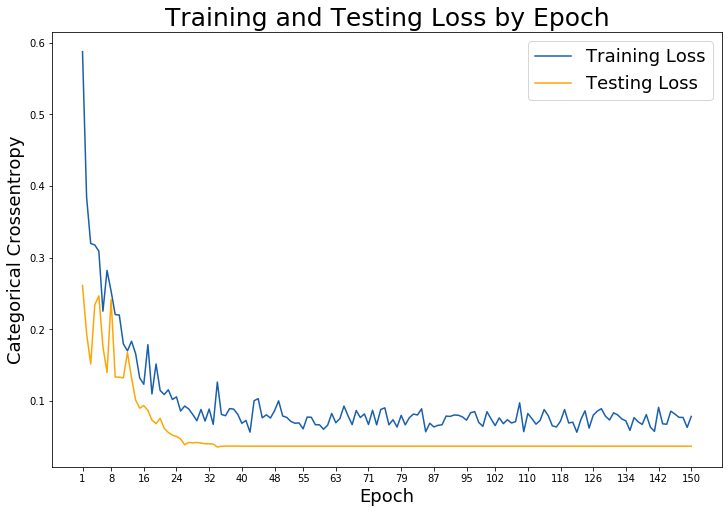

In [267]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

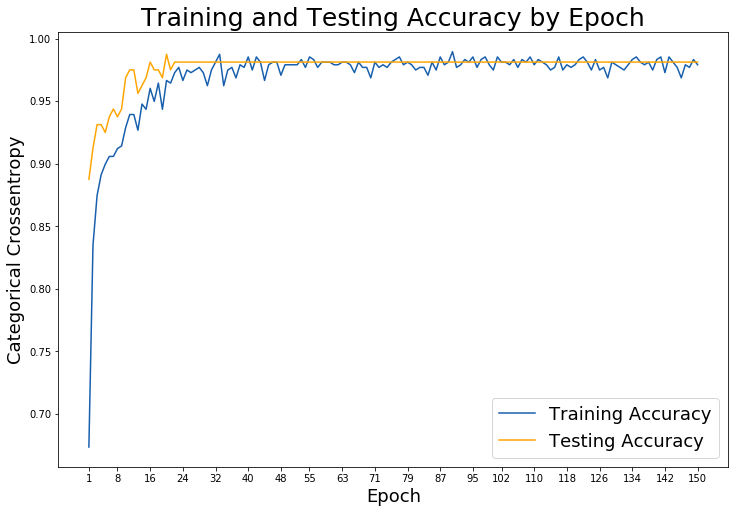

In [268]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train accuracy and accuracy loss over epochs.
train_loss = history.history['acc']
test_loss = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing accuracy over epochs.
plt.plot(train_loss, label='Training Accuracy', color='#185fad')
plt.plot(test_loss, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

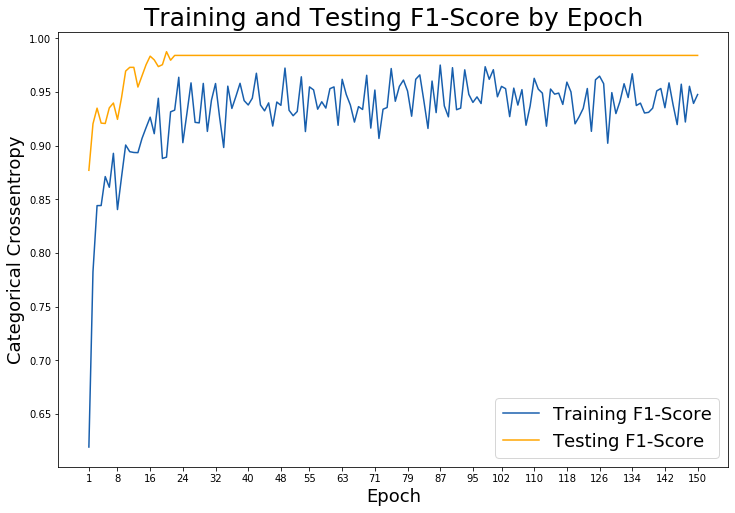

In [269]:
ticks_1 = (np.linspace(0, epochs-1, 20).astype(int))
ticks_2 = (np.linspace(1, epochs, 20).astype(int))

# Check out our train accuracy and accuracy loss over epochs.
train_loss = history.history['f1']
test_loss = history.history['val_f1']

# Set figure size.
plt.figure(figsize=(12, 8))

# Gaenerate line plot of training, testing accuracy over epochs.
plt.plot(train_loss, label='Training F1-Score', color='#185fad')
plt.plot(test_loss, label='Testing F1-Score', color='orange')

# Set title
plt.title('Training and Testing F1-Score by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(ticks_1, ticks_2)
plt.legend(fontsize = 18);

In [59]:
from keras import backend as K
model = Sequential()

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model.compile(loss='binary_crossentropy',
          optimizer= "adam",
          metrics=[f1])

W0826 18:50:43.893471 4635325888 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 18:50:43.934376 4635325888 deprecation_wrapper.py:119] From /anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [277]:
test_master_w_predictions = pd.merge(test_master, predicted_player_nn, left_on='Player_name', right_on='Player_name')
test_master_w_predictions = pd.merge(test_master_w_predictions, predicted_player, left_on='Player_name', right_on='Player_name')
test_master_w_predictions.drop(columns=['lr_class', 'lr_class', 'tree_class', 'ada_class', 'knn_class', 'bag_class', 'svc', 'grad', 'forest_class', 'DRAFT_YEAR+1_x', 'DRAFT_YEAR+1_y'], inplace=True)
test_master_w_predictions.head()

,Player_name,player_id,SEASON,Tm_x,Draft_team,Pk,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,College,Yrs,PTS,TRB,AST,FG%,3P%,FT%,PPG,RPG,APG,draft_round,target,neural,DRAFT_YEAR+1,tot
0,Bam Adebayo,adebaba01,2019,MIA,MIA,14.0,C,21,82,1913,17.9,0.623,0.031,0.465,9.2,24.0,16.6,14.2,1.8,3.0,17.1,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4,University of Kentucky,2.0,1206.0,978.0,285.0,0.550,0.136,0.728,8.0,6.5,1.9,1.0,0,0,2018.0,3
1,Jarrett Allen,allenja01,2019,BRK,BRK,22.0,C,20,80,2096,18.5,0.632,0.079,0.489,9.6,24.0,16.8,7.9,1.0,4.5,13.0,15.9,4.4,3.3,7.6,0.175,-0.7,3.2,2.5,2.4,University of Texas at Austin,2.0,1460.0,1060.0,159.0,0.590,0.183,0.732,9.6,7.0,1.0,1.0,0,1,2018.0,3
2,Kadeem Allen,allenka01,2019,NYK,BOS,53.0,SG,26,19,416,16.2,0.574,0.255,0.383,2.0,11.1,6.4,28.7,1.9,0.8,13.6,19.6,0.7,0.2,1.0,0.111,0.5,-1.6,-1.1,0.1,University of Arizona,2.0,208.0,62.0,88.0,0.436,0.362,0.778,5.6,1.7,2.4,2.0,0,0,2018.0,0
3,Ike Anigbogu,anigbik01,2019,IND,IND,47.0,C,20,3,6,-6.0,0.000,0.000,0.000,18.9,36.2,27.7,19.4,0.0,14.8,25.0,29.1,-0.1,0.0,-0.1,-0.480,-22.5,8.5,-14.0,0.0,University of California Los Angeles,2.0,13.0,12.0,1.0,0.333,0.000,0.833,0.9,0.9,0.1,2.0,0,0,2018.0,0
4,OG Anunoby,anunoog01,2019,TOR,TOR,23.0,SF,21,67,1352,9.8,0.544,0.500,0.153,4.8,10.8,7.9,4.7,1.6,1.3,11.3,15.5,0.3,1.7,2.0,0.070,-1.3,0.1,-1.2,0.3,Indiana University,2.0,907.0,381.0,102.0,0.461,0.351,0.605,6.4,2.7,0.7,1.0,0,0,2018.0,0


In [274]:
fig = px.scatter_3d(test_master_w_predictions, x='VORP', y='WS', z='MP',
            color='neural', 
            hover_name='Player_name', 
            hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age'], 
            symbol='neural')
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# fig.update_layout(scene=dict(xaxis=dict(range=[-15,10],),))
fig.update_layout(legend_orientation="h")
fig.update_layout(
    title=go.layout.Title(
        text="Players Classified By Neural Net: VROP, WS & Minutes Played"))
fig.show()

# plotly.offline.plot(fig, filename='html_files/ws_vorp_mp.html')

In [145]:
fig = px.scatter(test_master_w_predictions, x='BPM', y='WS',
            color='neural', hover_name='Player_name', hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age'], 
            color_continuous_scale='balance',
            symbol='neural')
fig.update_traces(marker=dict(size=10,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_xaxes(range=[-15, 7])
fig.update_layout(legend_orientation="h")
fig.show()
# plotly.offline.plot(fig, filename='html_files/ws_vorp.html')

In [115]:
fig = px.scatter(test_master_w_predictions, x='WS', y='VORP',
              color='neural', hover_name='Player_name', hover_data=['USG%', 'PER', 'MP', 'VORP', 'Age', 'RPG'], color_continuous_scale=px.colors.diverging.PiYG)
# fig.update_xaxes(range=[-2, 4.5])
fig.show()


In [278]:
test_master_w_predictions.corr()[['tot', 'neural']].sort_values('neural', ascending=False)


,tot,neural
neural,0.797887,1.000000
tot,1.000000,0.797887
PPG,0.613434,0.581070
PTS,0.617390,0.573486
WS,0.656130,0.560028
OWS,0.608334,0.531396
RPG,0.656514,0.524444
target,0.392185,0.505041
MP,0.539640,0.501516
TRB,0.599920,0.478229
